In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD


# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)

# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))

action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))

actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

In [7]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

In [8]:
# Setup controller

from stage.controllers.tsmpc import TSMPC

plan_horizon = 30
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = TSMPC(dynamics, task.step_cost, actor,
                   plan_horizon, n_particles, pop_size)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
controller.regularize(0)
_ = learner.learn(10, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 21.63epoch(s)/s, Training loss MSE=1.199221]


Iteration:  0
avg. decision time:  0.004364695549011231
obs. reward:  -255.1713
act. reward:  -1.2806573


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.05epoch(s)/s, Training loss MSE=2.0586414]


Iteration:  1
avg. decision time:  0.1295767307281494
obs. reward:  -230.36826
act. reward:  -1.520026


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.07epoch(s)/s, Training loss MSE=0.6161471]


Iteration:  2
avg. decision time:  0.13046178579330445
obs. reward:  -232.0891
act. reward:  -0.70661193


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.01epoch(s)/s, Training loss MSE=0.4134004]


Iteration:  3
avg. decision time:  0.12985511302947997
obs. reward:  -428.48233
act. reward:  -0.39478225


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.26epoch(s)/s, Training loss MSE=0.27528447]


Iteration:  4
avg. decision time:  0.1300402331352234
obs. reward:  -177.42465
act. reward:  -0.30908456


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.76epoch(s)/s, Training loss MSE=0.19830826]


Iteration:  5
avg. decision time:  0.12922746658325196
obs. reward:  -46.447857
act. reward:  -0.5411735


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.39epoch(s)/s, Training loss MSE=0.1243813]


Iteration:  6
avg. decision time:  0.12929849863052367
obs. reward:  -32.79568
act. reward:  -0.89533347


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.10epoch(s)/s, Training loss MSE=0.17085718]


Iteration:  7
avg. decision time:  0.12952914953231812
obs. reward:  -780.0935
act. reward:  -1.336501


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.83epoch(s)/s, Training loss MSE=0.15107504]


Iteration:  8
avg. decision time:  0.12949107885360717
obs. reward:  -31.134249
act. reward:  -1.0132444


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.65epoch(s)/s, Training loss MSE=0.11858016]

Iteration:  9
avg. decision time:  0.12990928888320924
obs. reward:  -31.290659
act. reward:  -1.1250196


In [17]:
controller.regularize(1)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.19697312116622925
obs. reward:  -35.30224
act. reward:  -0.9034974


In [18]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(0.5437, grad_fn=<MeanBackward0>)
tensor(0.2199, grad_fn=<StdBackward0>)


In [19]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.step_cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [20]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [21]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

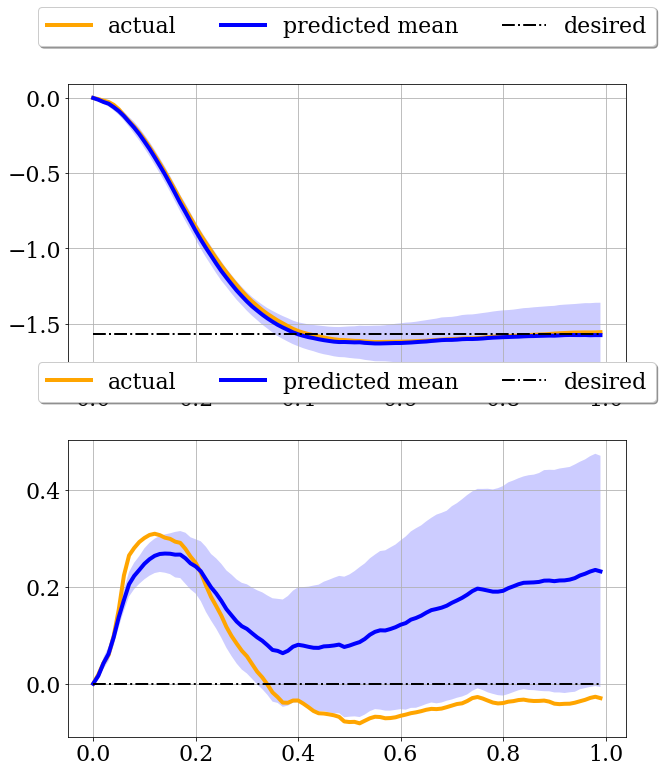

In [22]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
#     _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')